In [1]:
import glob
import pickle
import numpy as np
from numpy.polynomial import Polynomial
from scipy import ndimage, signal, interpolate, integrate
#import matplotlib
#matplotlib.use('PDF')
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014, turn_physical_off, MiyamotoNagaiPotential, plotDensities,evaluateDensities,plotPotentials
from galpy.util import bovy_conversion, save_pickles, bovy_coords, bovy_plot
import pal5_util
#import gd1_util
#from gd1_util import R0, V0
#import custom_stripping_df
import seaborn as sns
import astropy.units as u
from galpy import potential
%pylab inline
from matplotlib import cm, pyplot
from galpy.potential import DehnenSmoothWrapperPotential as DehnenWrap
import SCFbar_util

ro=8.
vo=220.

#from matplotlib.ticker import FuncFormatter, NullFormatter

def galcencyl_to_lbd(R,phi,Z,degree=True):
    xyz=bovy_coords.galcencyl_to_XYZ(R,phi,Z)
    lbd=bovy_coords.XYZ_to_lbd(xyz[0],xyz[1],xyz[2],degree=degree)
    return lbd[0], lbd[1], lbd[2]

Populating the interactive namespace from numpy and matplotlib


In [2]:
Ac,As=SCFbar_util.compute_Acos_Asin()

Mbar=10**10.
pat_speed=40.
ang=27.

barpot,nobarpot=SCFbar_util.Particle_Spray_MWPotentialSCFbar(mbar=Mbar,Acos=Ac,Asin=As,t_on=-5.,tgrow=2.)

In [6]:
fo='test_trail.dat'
SCFbar_util.sample_perturbed_pal5_new(100,barpot,nobarpot,fo=fo)
#SCFbar_util.sample_perturbed_pal5_new(20,barpot,nobarpot,trailing=False,fo=fo)

In [ ]:
N=100

sdf_trailing= pal5_util.setup_pal5model(pot=nobarpot)
R,vR,vT,z,vz,phi,dt= sdf_trailing.sample(n=N,returndt=True)

In [ ]:
def sample_perturbed_pal5_new(N,barpot,nobarpot,fo='blah_trailing.dat',trailing=True,tpal5age=5.):
    
        tage=numpy.linspace(0.,-tpal5age,1001)/bovy_conversion.time_in_Gyr(220.,8.)
        
        if trailing :
            sdf_trailing= pal5_util.setup_pal5model(pot=nobarpot)
            R,vR,vT,z,vz,phi,dt= sdf_trailing.sample(n=N,returndt=True)
            fo=open(fo,'w')
          
        
        else :
            sdf_leading= pal5_util.setup_pal5model(pot=nobarpot,leading=True)
            R,vR,vT,z,vz,phi,dt= sdf_leading.sample(n=N,returndt=True)
            fo_lead=fo.replace('trailing','leading')
            fo=open(fo_lead,'w')
              
        #integrate Pal 5 progenitor in barpot all the way back to 5 Gyrs, 
        #from this orbits will be extracted by interpolation in the for loop
        pal5_bar= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,solarmotion=[-11.1,24.,7.25])
        pal5_bar.integrate(tage,barpot)


        #integrate Pal 5 progenitor in nobarpot all the way back to 5 Gyrs, 
        #from this orbits will be extracted by interpolation in the for loop   
        pal5_nobar= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,solarmotion=[-11.1,24.,7.25]) 
        pal5_nobar.integrate(tage,nobarpot)

        pal5_bar.turn_physical_off()
        pal5_nobar.turn_physical_off()

        finalR= numpy.empty(N)
        finalvR=numpy.empty(N)
        finalvT=numpy.empty(N)
        finalvz=numpy.empty(N)
        finalphi= numpy.empty(N)
        finalz= numpy.empty(N)
        tt=numpy.empty(N)

        for ii in range(N):

                o= Orbit([R[ii],vR[ii],vT[ii],z[ii],vz[ii],phi[ii]])
                o.turn_physical_off()
                ts= numpy.linspace(0.,-dt[ii],1001)

                o.integrate(ts,nobarpot)

                #extract the orbit at the stripping time from the above integrated orbit
                unp_orb=numpy.array([o.x(ts[-1]),o.y(ts[-1]),o.z(ts[-1]),o.vx(ts[-1]),o.vy(ts[-1]),o.vz(ts[-1])])
                pal5_orb_bar= numpy.array([pal5_bar.x(ts[-1]),pal5_bar.y(ts[-1]),pal5_bar.z(ts[-1]),pal5_bar.vx(ts[-1]),pal5_bar.vy(ts[-1]),pal5_bar.vz(ts[-1])])
                pal5_orb_nobar= numpy.array([pal5_nobar.x(ts[-1]),pal5_nobar.y(ts[-1]),pal5_nobar.z(ts[-1]),pal5_nobar.vx(ts[-1]),pal5_nobar.vy(ts[-1]),pal5_nobar.vz(ts[-1])])

                #print (unp_orb)
                #print (pal5_orb_bar)  
                #print (pal5_orb_nobar)

                #subtract Pal 5 orb in nobarpot and add Pal 5 orbit in barpot
                pert_orb= (unp_orb - pal5_orb_nobar) + pal5_orb_bar

                #print (unp_orb,dt[ii]*bovy_conversion.time_in_Gyr(220.,8.))
                #print (pert_orb,dt[ii]*bovy_conversion.time_in_Gyr(220.,8.))
                #(R,phi,Z)
                #vR,vT,vz
                #vxvv=[R,vR,vT,z,vz,phi]
                pert_orb_RpZ= bovy_coords.rect_to_cyl(pert_orb[0],pert_orb[1],pert_orb[2])
                pert_orb_vRpZ= bovy_coords.rect_to_cyl_vec(pert_orb[3],pert_orb[4],pert_orb[5],pert_orb[0],pert_orb[1],pert_orb[2])
                pert_orb=Orbit([pert_orb_RpZ[0],pert_orb_vRpZ[0],pert_orb_vRpZ[1],pert_orb_RpZ[2],pert_orb_vRpZ[2],pert_orb_RpZ[1]])

                ts_future= numpy.linspace(-dt[ii],0.,1001)
                #forward integrate in barred potential
                pert_orb.integrate(ts_future,barpot)
                finalR[ii]= pert_orb.R(ts_future[-1])
                finalphi[ii]= pert_orb.phi(ts_future[-1])
                finalz[ii]= pert_orb.z(ts_future[-1])
                finalvR[ii]=pert_orb.vR(ts_future[-1])
                finalvT[ii]=pert_orb.vT(ts_future[-1])
                finalvz[ii]=pert_orb.vz(ts_future[-1])
                tt[ii]=dt[ii]
                
        fo.write("#R   phi   z   vR    vT    vz    ts" + "\n")
    
        for jj in range(N):
            fo.write(str(finalR[jj]) + "   " + str(finalphi[jj]) + "   " + str(finalz[jj]) + "   " + str(finalvR[jj]) + "   " + str(finalvT[jj]) + "   " + str(finalvz[jj]) + "   " + str(tt[jj]) + "\n")
        
        fo.close()
    
        return None

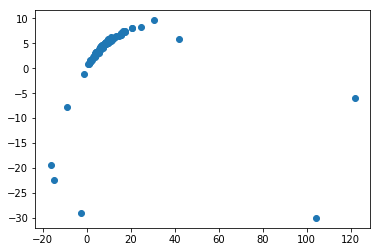

In [7]:
dat=np.loadtxt('test_trail.dat')
R=dat[:,0]
phi=dat[:,1]
z=dat[:,2]

def galcencyl_to_lbd(R,phi,Z,degree=True):
        xyz=bovy_coords.galcencyl_to_XYZ(R,phi,Z)
        l=[]
        b=[]
        d=[]
        for ii in range(len(xyz)):
            lbd=bovy_coords.XYZ_to_lbd(xyz[ii][0],xyz[ii][1],xyz[ii][2],degree=degree)
            l.append(lbd[0])
            b.append(lbd[1])
            d.append(lbd[2])
            
        return (l,b,d)

l_t,b_t,d_t=np.array(galcencyl_to_lbd(R,phi,z))
radec_t=bovy_coords.lb_to_radec(l_t,b_t,degree=True) 

        
mxieta_t= pal5_util.radec_to_pal5xieta(radec_t[:,0],radec_t[:,1],degree=True)
xi_t= mxieta_t[:,0]
eta_t=mxieta_t[:,1]

plt.figure()
plt.scatter(xi_t,eta_t)
plt.show()

In [10]:
def sample_perturbed_pal5_new_noprog(N,barpot,nobarpot,fo='blah_trailing.dat',trailing=True,tpal5age=5.):
    
        tage=numpy.linspace(0.,-tpal5age,1001)/bovy_conversion.time_in_Gyr(220.,8.)
        
        if trailing :
            sdf_trailing= pal5_util.setup_pal5model(pot=nobarpot)
            R,vR,vT,z,vz,phi,dt= sdf_trailing.sample(n=N,returndt=True)
            fo=open(fo,'w')
          
        
        else :
            sdf_leading= pal5_util.setup_pal5model(pot=nobarpot,leading=True)
            R,vR,vT,z,vz,phi,dt= sdf_leading.sample(n=N,returndt=True)
            fo_lead=fo.replace('trailing','leading')
            fo=open(fo_lead,'w')
              
        
        finalR= numpy.empty(N)
        finalvR=numpy.empty(N)
        finalvT=numpy.empty(N)
        finalvz=numpy.empty(N)
        finalphi= numpy.empty(N)
        finalz= numpy.empty(N)
        tt=numpy.empty(N)

        for ii in range(N):

                o= Orbit([R[ii],vR[ii],vT[ii],z[ii],vz[ii],phi[ii]])
                o.turn_physical_off()
                ts= numpy.linspace(0.,-dt[ii],1001)

                o.integrate(ts,nobarpot)
                orb=Orbit([o.R(ts[-1]),o.vR(ts[-1]),o.vT(ts[-1]),o.z(ts[-1]),o.vz(ts[-1]),o.phi(ts[-1])])
                                
                ts_future= numpy.linspace(-dt[ii],0.,1001)
                #forward integrate in barred potential
                orb.integrate(ts_future,barpot)
                finalR[ii]= orb.R(ts_future[-1])
                finalphi[ii]= orb.phi(ts_future[-1])
                finalz[ii]= orb.z(ts_future[-1])
                finalvR[ii]=orb.vR(ts_future[-1])
                finalvT[ii]=orb.vT(ts_future[-1])
                finalvz[ii]=orb.vz(ts_future[-1])
                tt[ii]=dt[ii]
                
        fo.write("#R   phi   z   vR    vT    vz    ts" + "\n")
    
        for jj in range(N):
            fo.write(str(finalR[jj]) + "   " + str(finalphi[jj]) + "   " + str(finalz[jj]) + "   " + str(finalvR[jj]) + "   " + str(finalvT[jj]) + "   " + str(finalvz[jj]) + "   " + str(tt[jj]) + "\n")
        
        fo.close()
    
        return None

In [11]:
sample_perturbed_pal5_new_noprog(50,barpot,nobarpot,fo='test_trail.dat')

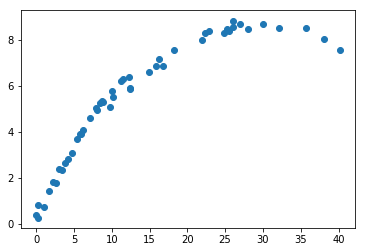

In [12]:
dat=np.loadtxt('test_trail.dat')
R=dat[:,0]
phi=dat[:,1]
z=dat[:,2]

def galcencyl_to_lbd(R,phi,Z,degree=True):
        xyz=bovy_coords.galcencyl_to_XYZ(R,phi,Z)
        l=[]
        b=[]
        d=[]
        for ii in range(len(xyz)):
            lbd=bovy_coords.XYZ_to_lbd(xyz[ii][0],xyz[ii][1],xyz[ii][2],degree=degree)
            l.append(lbd[0])
            b.append(lbd[1])
            d.append(lbd[2])
            
        return (l,b,d)

l_t,b_t,d_t=np.array(galcencyl_to_lbd(R,phi,z))
radec_t=bovy_coords.lb_to_radec(l_t,b_t,degree=True) 

        
mxieta_t= pal5_util.radec_to_pal5xieta(radec_t[:,0],radec_t[:,1],degree=True)
xi_t= mxieta_t[:,0]
eta_t=mxieta_t[:,1]

plt.figure()
plt.scatter(xi_t,eta_t)
plt.show()

In [ ]:
def sample_perturbed_Pal5(N,barpot,barpot_invert,nobarpot,prog_barpot,prog_barpot_invert,prog_nobarpot,fo='blah_trailing.dat',trailing=True,tpal5age=5.,t_on=2.,tgrow=2,pat_speed=40.):
    #Sample N points from the smooth model today 
    
    tpal5age=tpal5age/bovy_conversion.time_in_Gyr(220.,8.)
       
    if trailing :
          sdf_trailing= pal5_util.setup_pal5model(pot=nobarpot)
   
          R,vR,vT,z,vz,phi,dt= sdf_trailing.sample(n=N,returndt=True)
          fo=open(fo,'w')
        
    else :
          sdf_leading= pal5_util.setup_pal5model(pot=nobarpot,leading=True)
          R,vR,vT,z,vz,phi,dt= sdf_leading.sample(n=N,returndt=True)
          fo_lead=fo.replace('trailing','leading')
          fo=open(fo_lead,'w')
        
    tage=numpy.linspace(0.,tpal5age,1001)
    
    #integrate Pal 5 progenitor in barpot all the way back to 5 Gyrs, 
    #from this orbits will be extracted by interpolation in the for loop
    pal5_bar= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,solarmotion=[-11.1,24.,7.25]).flip() 
    pal5_bar.integrate(tage,prog_barpot_invert)
    
            
    #integrate Pal 5 progenitor in nobarpot all the way back to 5 Gyrs, 
    #from this orbits will be extracted by interpolation in the for loop   
    pal5_nobar= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,solarmotion=[-11.1,24.,7.25]).flip() 
    pal5_nobar.integrate(tage,prog_nobarpot)
    
    pal5_bar.turn_physical_off()
    pal5_nobar.turn_physical_off()
    
    finalR= numpy.empty(N)
    finalvR=numpy.empty(N)
    finalvT=numpy.empty(N)
    finalvz=numpy.empty(N)
    finalphi= numpy.empty(N)
    finalz= numpy.empty(N)
    tt=numpy.empty(N)

    tform = tform_from_t_on(t_on=t_on,pat_speed=pat_speed,tgrow=tgrow) #in galpy
    t_on=t_on/bovy_conversion.time_in_Gyr(220.,8.)

    for ii in range(N):
        
        o= Orbit([R[ii],vR[ii],vT[ii],z[ii],vz[ii],phi[ii]]).flip() # flip flips the velocities for backwards integration
        o.turn_physical_off()
        ts= numpy.linspace(0.,dt[ii],1001)
    
        #for integrating in barpot, time starts 5 Gyrs in the past and goes forward
        ts_future= numpy.linspace(tpal5age - dt[ii],tpal5age,1001)
    
        o.integrate(ts,nobarpot)
        #unp_orb=o(ts[-1]).flip()._orb.vxvv
        
        #extract the orbit at the stripping time from the above integrated orbit
        #pal5_orb_bar = pal5_bar(ts[-1]).flip()._orb.vxvv
        #pal5_orb_nobar = pal5_nobar(ts[-1]).flip()._orb.vxvv
        
        unp_orb=numpy.array([o.x(ts[-1]),o.y(ts[-1]),o.z(ts[-1]),-o.vx(ts[-1]),-o.vy(ts[-1]),-o.vz(ts[-1])])
        pal5_orb_bar= numpy.array([pal5_bar.x(ts[-1]),pal5_bar.y(ts[-1]),pal5_bar.z(ts[-1]),-pal5_bar.vx(ts[-1]),-pal5_bar.vy(ts[-1]),-pal5_bar.vz(ts[-1])])
        pal5_orb_nobar= numpy.array([pal5_nobar.x(ts[-1]),pal5_nobar.y(ts[-1]),pal5_nobar.z(ts[-1]),-pal5_nobar.vx(ts[-1]),-pal5_nobar.vy(ts[-1]),-pal5_nobar.vz(ts[-1])])
        
        #print (unp_orb)
        #print (pal5_orb_bar)  
        #print (pal5_orb_nobar)
              
        #subtract Pal 5 orb in nobarpot and add Pal 5 orbit in barpot
        #pert_orb=(np.array(unp_orb) - np.array(pal5_orb_nobar)) + np.array(pal5_orb_bar)
        #pert_orb=Orbit(list(pert_orb))
        
        pert_orb= unp_orb - pal5_orb_nobar + pal5_orb_bar
        
        print (unp_orb,dt[ii]*bovy_conversion.time_in_Gyr(220.,8.))
        print (pert_orb,dt[ii]*bovy_conversion.time_in_Gyr(220.,8.))
        #(R,phi,Z)
        #vR,vT,vz
        #vxvv=[R,vR,vT,z,vz,phi]
        pert_orb_RpZ= bovy_coords.rect_to_cyl(pert_orb[0],pert_orb[1],pert_orb[2])
        pert_orb_vRpZ= bovy_coords.rect_to_cyl_vec(pert_orb[3],pert_orb[4],pert_orb[5],pert_orb[0],pert_orb[1],pert_orb[2])
        pert_orb=Orbit([pert_orb_RpZ[0],pert_orb_vRpZ[0],pert_orb_vRpZ[1],pert_orb_RpZ[2],pert_orb_vRpZ[2],pert_orb_RpZ[1]])
        
        
        #forward integrate in barred potential
        pert_orb.integrate(ts_future,barpot)
        finalR[ii]= pert_orb.R(ts_future[-1])
        finalphi[ii]= pert_orb.phi(ts_future[-1])
        finalz[ii]= pert_orb.z(ts_future[-1])
        finalvR[ii]=pert_orb.vR(ts_future[-1])
        finalvT[ii]=pert_orb.vT(ts_future[-1])
        finalvz[ii]=pert_orb.vz(ts_future[-1])
        tt[ii]=dt[ii]
    
    fo.write("#R   phi   z   vR    vT    vz    ts" + "\n")
    
    for jj in range(N):
        fo.write(str(finalR[jj]) + "   " + str(finalphi[jj]) + "   " + str(finalz[jj]) + "   " + str(finalvR[jj]) + "   " + str(finalvT[jj]) + "   " + str(finalvz[jj]) + "   " + str(tt[jj]) + "\n")
        
    fo.close()
    
    return None

In [ ]:
pal5_0= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,solarmotion=[-11.1,24.,7.25]).flip() 
pal5_1= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,solarmotion=[-11.1,24.,7.25])

t0=np.linspace(0.,2.,1001)/bovy_conversion.time_in_Gyr(220.,8.)
t1=np.linspace(0.,-2.,1001)/bovy_conversion.time_in_Gyr(220.,8.)

pal5_0.integrate(t0,MWPotential2014)
pal5_0_0=Orbit(pal5_0(t0[-1]).flip()._orb.vxvv)
print (pal5_0(t0[-1]).flip()._orb.vxvv)       
pal5_1.integrate(t1,MWPotential2014)
print (pal5_1(t1[-1])._orb.vxvv)       
pal5_1_1=Orbit(pal5_1(t1[-1])._orb.vxvv)

pal5_0_0.integrate(t0,MWPotential2014)
print (pal5_0_0(t0[-1])._orb.vxvv)

t11=np.linspace(-2.,0.,1001)/bovy_conversion.time_in_Gyr(220.,8.)
pal5_1_1.integrate(t11,MWPotential2014)

print (pal5_1_1(t11[-1])._orb.vxvv)

